In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler # Used for scaling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix


In [4]:

# Import individual classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import joblib # For saving/loading models and scalers


In [5]:

# --- 1. Load the Processed Dataset ---
# IMPORTANT: Ensure 'processed_train_data.csv' is in the same directory as this script,
# or provide the full correct path.
try:
    df = pd.read_csv('processed_train_data.csv')
    print("Processed dataset loaded successfully.")
    print(df.head())
    print(df.info())
except FileNotFoundError:
    print("Error: 'processed_train_data.csv' not found. Please ensure your data analysis script has been run and the file is present.")
    print("Exiting model training script.")
    exit()


Processed dataset loaded successfully.
   duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       19     9        491          0     0   
1         0              2       41     9        146          0     0   
2         0              1       46     5          0          0     0   
3         0              1       22     9        232       8153     0   
4         0              1       22     9        199        420     0   

   wrong_fragment  urgent  num_failed_logins  ...  is_guest_login  count  \
0               0       0                  0  ...               0      2   
1               0       0                  0  ...               0     13   
2               0       0                  0  ...               0    123   
3               0       0                  0  ...               0      5   
4               0       0                  0  ...               0     30   

   srv_count  diff_srv_rate  srv_diff_host_rate  dst_host_count  

In [6]:

# --- 2. Separate Features (X) and Target (y) ---
# 'class' is the target variable (0 for anomaly, 1 for normal )
X = df.drop('class', axis=1)
y = df['class']

print(f"\nOriginal X shape: {X.shape}")
print(f"Original y shape: {y.shape}")
print(f"Original class distribution:\n{y.value_counts()}")



Original X shape: (25192, 27)
Original y shape: (25192,)
Original class distribution:
class
1    13449
0    11743
Name: count, dtype: int64


In [7]:

# --- 3. Handle Class Imbalance (Undersampling Anomalies) ---
print("\n--- Handling Class Imbalance (Undersampling Anomalies) ---")
normal = X[y == 1]
anomalies = X[y == 0]

# Select random 5% of anomalies relative to the normal class size
num_anomalies_to_select = int(len(normal) * 0.05)
if num_anomalies_to_select == 0 and len(anomalies) > 0:
    num_anomalies_to_select = 1
elif num_anomalies_to_select > len(anomalies):
    num_anomalies_to_select = len(anomalies)

if num_anomalies_to_select > 0:
    anomaly_indices = np.random.choice(anomalies.index, num_anomalies_to_select, replace=False)
    selected_anomalies_X = X.loc[anomaly_indices]
    selected_anomalies_y = y.loc[anomaly_indices]
else:
    selected_anomalies_X = pd.DataFrame()
    selected_anomalies_y = pd.Series(dtype=int)

# Combine normal class with selected anomalies
X_balanced = pd.concat([normal, selected_anomalies_X])
y_balanced = pd.concat([y[y == 1], selected_anomalies_y])

# --- Custom Shuffle Function ---
def shuffle_data(features, labels):
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    return features.iloc[indices], labels.iloc[indices] # Use .iloc for positional indexing after shuffle

# Shuffle the combined data to mix normal and anomaly instances
X_balanced, y_balanced = shuffle_data(X_balanced, y_balanced)

print(f"Balanced X shape: {X_balanced.shape}")
print(f"Balanced y shape: {y_balanced.shape}")
print(f"Balanced class distribution:\n{y_balanced.value_counts()}")



--- Handling Class Imbalance (Undersampling Anomalies) ---
Balanced X shape: (14121, 27)
Balanced y shape: (14121,)
Balanced class distribution:
class
1    13449
0      672
Name: count, dtype: int64


In [8]:


# --- 4. Feature Scaling ---
# MinMaxScaler is generally good for Neural Networks, and often for other models too.
# RobustScaler (from your original code) is good if you have many outliers.
# We'll use MinMaxScaler here for consistency with the NN model.
print("\n--- Applying MinMaxScaler to Features ---")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_balanced)

joblib.dump(scaler, 'minmax_scaler.pkl')


--- Applying MinMaxScaler to Features ---


['minmax_scaler.pkl']

In [9]:
from sklearn.model_selection import train_test_split

# Split the balanced and scaled data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# Convert back to DataFrames for saving
X_train_df = pd.DataFrame(X_train, columns=X_balanced.columns)
X_test_df = pd.DataFrame(X_test, columns=X_balanced.columns)
y_train_df = pd.DataFrame(y_train.values, columns=['class'])
y_test_df = pd.DataFrame(y_test.values, columns=['class'])

# Combine features and labels for saving
train_df = pd.concat([X_train_df, y_train_df], axis=1)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

# Save to CSV
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("\nTrain and test datasets saved as 'train_data.csv' and 'test_data.csv'")
print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")




Train and test datasets saved as 'train_data.csv' and 'test_data.csv'
Train shape: (9884, 28) | Test shape: (4237, 28)


In [10]:

# --- 5. Define Scoring Metrics for Cross-Validation ---
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary')
}


In [11]:

# --- 6. Custom Function to Display Results (from your original code) ---
def display_results(results):
    metrics_data = {
        "Metric": ["Fit Time", "Score Time", "Accuracy", "Precision", "Recall", "F1 Score"],
        "Value": [
            results["fit_time"].mean(),
            results["score_time"].mean(),
            results["test_accuracy"].mean(),
            results["test_precision"].mean(),
            results["test_recall"].mean(),
            results["test_f1_score"].mean(),
        ]
    }
    df_metrics = pd.DataFrame(metrics_data)
    df_metrics.set_index("Metric", inplace=True)
    return df_metrics.T # Transpose for better display as in your original snippet



In [12]:

# --- Training and Evaluating Classifiers Step-by-Step ---

# --- Classifier 1: Gaussian Naive Bayes ---
print("\n--- Training Gaussian Naive Bayes (GNB) ---")
NB = GaussianNB()
results_nb = cross_validate(NB, X_train_df, y_train_df['class'], cv=5, scoring=scoring, return_train_score=False)
print("Gaussian Naive Bayes Cross-Validation Results:")
print(display_results(results_nb))

# Fit the model on the full balanced dataset for saving
NB.fit(X_train_df, y_train_df['class'])
joblib.dump(NB, 'ids_gnb_model.pkl')
print("GNB model saved as 'ids_gnb_model.pkl'")




--- Training Gaussian Naive Bayes (GNB) ---
Gaussian Naive Bayes Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision    Recall  F1 Score
Value   0.008438    0.012166  0.159145   0.993281  0.118015  0.210532
GNB model saved as 'ids_gnb_model.pkl'


In [13]:

# --- Classifier 2: Logistic Regression ---
print("\n--- Training Logistic Regression (LR) ---")
# 'newton-cholesky' is often fast for smaller datasets and L2 regularization
LR = LogisticRegression(max_iter=7000, solver='newton-cholesky', random_state=42)
results_lr = cross_validate(LR, X_train_df, y_train_df['class'], cv=5, scoring=scoring, return_train_score=False)
print("\nLogistic Regression Cross-Validation Results:")
print(display_results(results_lr))

LR.fit(X_train_df, y_train_df['class'])
joblib.dump(LR, 'ids_lr_model.pkl')
print("LR model saved as 'ids_lr_model.pkl'")




--- Training Logistic Regression (LR) ---

Logistic Regression Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision  Recall  F1 Score
Value   0.026742     0.00863  0.984116   0.985223  0.9983  0.991718
LR model saved as 'ids_lr_model.pkl'


In [14]:

# --- Classifier 3: K-Nearest Neighbors (KNN) ---
print("\n--- Training K-Nearest Neighbors (KNN) ---")
# Default n_neighbors=5. You might tune this hyperparameter.
KNN = KNeighborsClassifier()
results_knn = cross_validate(KNN, X_train_df, y_train_df['class'], cv=5, scoring=scoring, return_train_score=False)
print("\nK-Nearest Neighbors Cross-Validation Results:")
print(display_results(results_knn))

KNN.fit(X_train_df, y_train_df['class'])
joblib.dump(KNN, 'ids_knn_model.pkl')
print("KNN model saved as 'ids_knn_model.pkl'")



--- Training K-Nearest Neighbors (KNN) ---

K-Nearest Neighbors Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision    Recall  F1 Score
Value   0.003707    0.159542  0.993424   0.995445  0.997663  0.996552
KNN model saved as 'ids_knn_model.pkl'


In [15]:


# --- Classifier 4: Linear Support Vector Classifier (LinearSVC) ---
print("\n--- Training LinearSVC ---")
# LinearSVC requires data to be scaled, which X_scaled already is.
# MinMaxScaler (0-1) is suitable, but StandardScaler (-1 to 1) is also common for SVMs.
# You might need to adjust max_iter or tolerance (tol) for convergence.
SVC = LinearSVC(max_iter=5000, random_state=42)
# Note: your original code used MinMaxScaler before LinearSVC, but X_scaled is already MinMax scaled.
# If you preferred RobustScaler for LinearSVC, you'd apply it here again after MinMaxScaler.
# For simplicity, we'll use the already scaled X_scaled.
results_svc = cross_validate(SVC, X_train_df, y_train_df['class'], cv=5, scoring=scoring, return_train_score=False)
print("\nLinearSVC Cross-Validation Results:")
print(display_results(results_svc))

SVC.fit(X_train_df, y_train_df['class'])
joblib.dump(SVC, 'ids_svc_model.pkl')
print("LinearSVC model saved as 'ids_svc_model.pkl'")




--- Training LinearSVC ---

LinearSVC Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision    Recall  F1 Score
Value   0.013012     0.00963  0.984925   0.985744  0.998619  0.992139
LinearSVC model saved as 'ids_svc_model.pkl'


In [16]:

# --- Classifier 5: Decision Tree Classifier (DTC) ---
print("\n--- Training Decision Tree Classifier (DTC) ---")
# 'entropy' is a good criterion for impurity.
DTC = DecisionTreeClassifier(criterion='entropy', random_state=42)
results_dtc = cross_validate(DTC, X_train_df, y_train_df['class'], cv=5, scoring=scoring, return_train_score=False)
print("\nDecision Tree Classifier Cross-Validation Results:")
print(display_results(results_dtc))

DTC.fit(X_train_df, y_train_df['class'])
joblib.dump(DTC, 'ids_dtc_model.pkl')
print("DTC model saved as 'ids_dtc_model.pkl'")




--- Training Decision Tree Classifier (DTC) ---

Decision Tree Classifier Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision    Recall  F1 Score
Value   0.019294    0.010186  0.997369   0.998831  0.998407  0.998619
DTC model saved as 'ids_dtc_model.pkl'


In [17]:

# --- Classifier 6: Random Forest Classifier (RFC) ---
print("\n--- Training Random Forest Classifier (RFC) ---")
# n_estimators is number of trees. 5 is very small; typically 100-500 is common.
# Using 100 as a more standard starting point for better performance.
RFC = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all CPU cores
results_rfc = cross_validate(RFC, X_train_df, y_train_df['class'], cv=5, scoring=scoring, return_train_score=False)
print("\nRandom Forest Classifier Cross-Validation Results:")
print(display_results(results_rfc))

RFC.fit(X_train_df, y_train_df['class'])
joblib.dump(RFC, 'ids_rfc_model.pkl')
print("RFC model saved as 'ids_rfc_model.pkl'")




--- Training Random Forest Classifier (RFC) ---

Random Forest Classifier Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision  Recall  F1 Score
Value   0.186026    0.050921   0.99828   0.998198     1.0  0.999098
RFC model saved as 'ids_rfc_model.pkl'


In [18]:

# --- Classifier 7: Voting Classifier (Ensemble) ---
print("\n--- Training Voting Classifier ---")
# Use the *trained* models from above or re-initialize if needed.
# For VotingClassifier, it's common to pass estimators that are already fit if you want to use
# their learned parameters or just initialize them and let cross_validate fit them.
# We'll pass the initialized ones so cross_validate fits them correctly within each fold.
VC = VotingClassifier(
    estimators=[
        ('KNN', KNeighborsClassifier()), # Re-initialize KNN for consistent cross-validation
        ('LR', LogisticRegression(max_iter=7000, solver='newton-cholesky', random_state=42)),
        ('DTC', DecisionTreeClassifier(criterion='entropy', random_state=42)),
        ('RFC', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ],
    voting='hard' # 'hard' for majority vote, 'soft' for probability averaging (if all support predict_proba)
)
results_vc = cross_validate(VC, X_train_df, y_train_df['class'], cv=5, scoring=scoring, return_train_score=False)
print("\nVoting Classifier Cross-Validation Results:")
print(display_results(results_vc))

VC.fit(X_train_df, y_train_df['class'])
joblib.dump(VC, 'ids_vc_model.pkl')
print("Voting Classifier model saved as 'ids_vc_model.pkl'")

print("\n--- All Classifier Training Complete ---")
print("Trained models and the scaler have been saved as .pkl files.")



--- Training Voting Classifier ---

Voting Classifier Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision    Recall  F1 Score
Value   0.228463    0.146497  0.997875   0.998408  0.999363  0.998885
Voting Classifier model saved as 'ids_vc_model.pkl'

--- All Classifier Training Complete ---
Trained models and the scaler have been saved as .pkl files.


In [19]:
test_df = pd.read_csv("test_data.csv")
X_test = test_df.drop("class", axis=1)
y_test = test_df["class"]



In [20]:
model = joblib.load("ids_gnb_model.pkl")


In [21]:
y_pred = model.predict(X_test)


In [22]:
from sklearn.metrics import classification_report, mean_squared_error
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 198    4]
 [3571  464]]

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.98      0.10       202
           1       0.99      0.11      0.21      4035

    accuracy                           0.16      4237
   macro avg       0.52      0.55      0.15      4237
weighted avg       0.95      0.16      0.20      4237




Total MSE: 0.8438


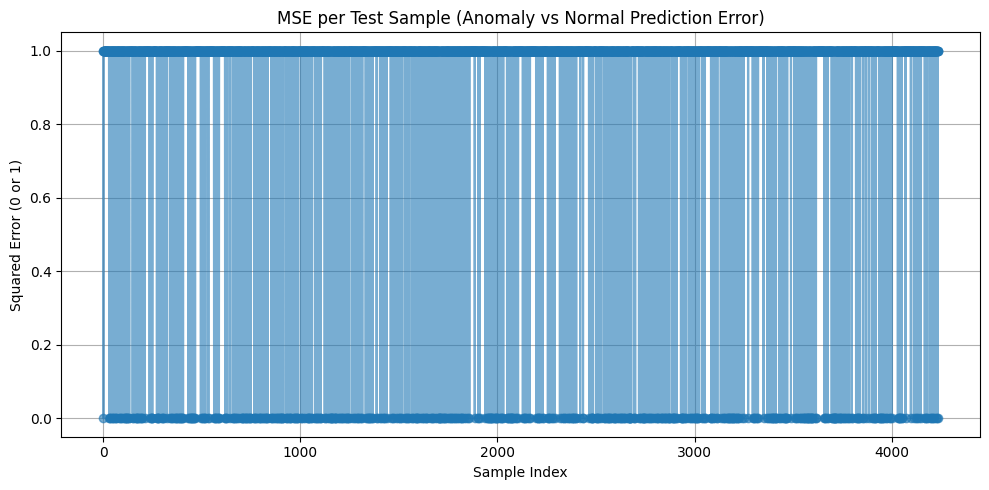

In [23]:
# Compute MSE for each individual prediction (squared difference)
mse_per_sample = (y_test - y_pred) ** 2

# Compute total MSE
total_mse = mean_squared_error(y_test, y_pred)
print(f"\nTotal MSE: {total_mse:.4f}")

# Plot the MSE over sample index
plt.figure(figsize=(10, 5))
plt.plot(mse_per_sample.values, marker='o', linestyle='-', alpha=0.6)
plt.title("MSE per Test Sample (Anomaly vs Normal Prediction Error)")
plt.xlabel("Sample Index")
plt.ylabel("Squared Error (0 or 1)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import joblib


In [25]:
print("\n--- Training Support Vector Machine (SVM) ---")

svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)



# Cross-validation (optional but useful)
results_svm = cross_validate(svm, X_train_df, y_train_df['class'], cv=5, scoring=scoring)

print("SVM Cross-Validation Results:")
print(display_results(results_svm))
print("SVM1 Cross-Validation Results:")


# Fit on full training data
svm.fit(X_train_df, y_train_df['class'])

# Save model
joblib.dump(svm, 'ids_svm_model.pkl')
print("SVM model saved as 'ids_svm_model.pkl'")




--- Training Support Vector Machine (SVM) ---
SVM Cross-Validation Results:
Metric  Fit Time  Score Time  Accuracy  Precision    Recall  F1 Score
Value   1.854827    0.131302  0.976123    0.99751  0.977374  0.987333
SVM1 Cross-Validation Results:
SVM model saved as 'ids_svm_model.pkl'


In [26]:
# Load test data
X_test = pd.read_csv("test_data.csv").drop("class", axis=1)
y_test = pd.read_csv("test_data.csv")["class"]

# Predict
y_pred = svm.predict(X_test)

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[ 193    9]
 [ 101 3934]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       202
           1       1.00      0.97      0.99      4035

    accuracy                           0.97      4237
   macro avg       0.83      0.97      0.88      4237
weighted avg       0.98      0.97      0.98      4237



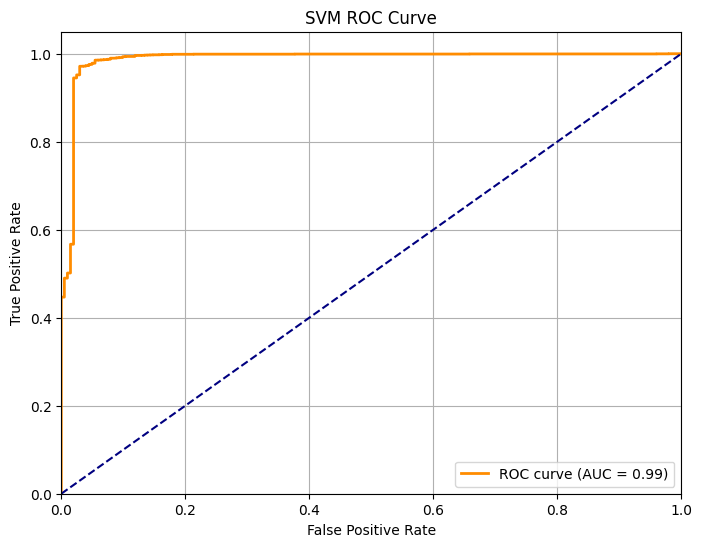

In [27]:
y_proba = svm.predict_proba(X_test)[:, 1]  # Probability of class 1 (normal)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # input layer
    Dropout(0.3),  # prevent overfitting
    Dense(64, activation='relu'),  # hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)



# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

# Evaluate on test data
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Predict probabilities
y_pred_prob = model.predict(X_test)
# Convert probs to class labels with threshold 0.5 (adjust if needed)
y_pred = (y_pred_prob >= 0.5).astype(int)




Epoch 1/30
248/248 - 1s - loss: 0.1438 - accuracy: 0.9543 - precision: 0.9648 - recall: 0.9880 - val_loss: 0.0540 - val_accuracy: 0.9838 - val_precision: 0.9854 - val_recall: 0.9979 - 1s/epoch - 6ms/step
Epoch 2/30
248/248 - 0s - loss: 0.0579 - accuracy: 0.9851 - precision: 0.9872 - recall: 0.9972 - val_loss: 0.0359 - val_accuracy: 0.9874 - val_precision: 0.9900 - val_recall: 0.9968 - 346ms/epoch - 1ms/step
Epoch 3/30
248/248 - 0s - loss: 0.0459 - accuracy: 0.9879 - precision: 0.9901 - recall: 0.9972 - val_loss: 0.0317 - val_accuracy: 0.9919 - val_precision: 0.9953 - val_recall: 0.9963 - 327ms/epoch - 1ms/step
Epoch 4/30
248/248 - 0s - loss: 0.0405 - accuracy: 0.9899 - precision: 0.9912 - recall: 0.9983 - val_loss: 0.0321 - val_accuracy: 0.9929 - val_precision: 0.9974 - val_recall: 0.9952 - 322ms/epoch - 1ms/step
Epoch 5/30
248/248 - 0s - loss: 0.0374 - accuracy: 0.9905 - precision: 0.9922 - recall: 0.9979 - val_loss: 0.0277 - val_accuracy: 0.9934 - val_precision: 0.9958 - val_recall: 

In [29]:
# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 185   17]
 [   1 4034]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       202
           1       1.00      1.00      1.00      4035

    accuracy                           1.00      4237
   macro avg       1.00      0.96      0.98      4237
weighted avg       1.00      1.00      1.00      4237



In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3584      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11905 (46.50 KB)
Trainable params: 11905 (46.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create the model
mlp = MLPClassifier(hidden_layer_sizes=(64, 64,32),  #3 hidden layers with 64 and 32 neurons
                    activation='relu',
                    solver='adam',
                    max_iter=100,
                    random_state=42)

# Train the model
mlp.fit(X_train, y_train.values.ravel())  # make sure y_train is 1D

# Predict on test data
y_pred = mlp.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 185   17]
 [   3 4032]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       202
           1       1.00      1.00      1.00      4035

    accuracy                           1.00      4237
   macro avg       0.99      0.96      0.97      4237
weighted avg       1.00      1.00      1.00      4237



c:\Users\User\anaconda3\envs\env_name\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [32]:
joblib.dump(mlp, 'mlp_model.pkl')

['mlp_model.pkl']